In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import beta
import matplotlib.colors
#from more_itertools import imap

In [29]:
#cmap = plt.get_cmap("tab10", 10)
colors=["red", "orange", "gold", "limegreen", "k", 
        "#550011", "purple", "seagreen"]

cmap = matplotlib.colors.ListedColormap(colors)
n_trials = 10000

In [3]:
sns.set_style("whitegrid")
get_ipython().run_line_magic('matplotlib', 'inline')

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [5]:
class Environment:
    def __init__(self, variants, payouts, n_trials, variance=False):
        self.variants = variants
        if variance:
            self.payouts = np.clip(payouts + np.random.normal(0, 0.04, size=len(variants)), 0, .2)
        else:
            self.payouts = payouts
        #self.payouts[5] = self.payouts[5] if i < n_trials/2 else 0.1
        self.n_trials = n_trials
        self.total_reward = 0
        self.n_k = len(variants)
        self.shape = (self.n_k, n_trials)
        
    def run(self, agent):
        """Run the simulation with the agent. 
        agent must be a class with choose_k and update methods."""
        
        for i in range(self.n_trials):
            # agent makes a choice
            x_chosen = agent.choose_k()
            # Environment returns reward
            reward = np.random.binomial(1, p=self.payouts[x_chosen])
            # agent learns of reward
            agent.reward = reward
            # agent updates parameters based on the data
            agent.update()
            self.total_reward += reward
        
        agent.collect_data()
        
        return self.total_reward

In [6]:
class BaseSampler:
    
    def __init__(self, env, n_samples=None, n_learning=None, e=0.05):
        self.env = env
        self.shape = (env.n_k, n_samples)
        self.variants = env.variants
        self.n_trials = env.n_trials
        self.payouts = env.payouts
        self.ad_i = np.zeros(env.n_trials)
        self.r_i = np.zeros(env.n_trials)
        self.thetas = np.zeros(self.n_trials)
        self.regret_i = np.zeros(env.n_trials)
        self.thetaregret = np.zeros(self.n_trials)
        
        self.a = np.ones(env.n_k) 
        self.b = np.ones(env.n_k) 
        self.theta = np.zeros(env.n_k)
        self.data = None
        self.reward = 0
        self.total_reward = 0
        self.k = 0
        self.i = 0
        
        self.n_samples = n_samples
        self.n_learning = n_learning
        self.e = e
        self.ep = np.random.uniform(0, 1, size=env.n_trials)
        self.exploit = (1 - e)
        
    def collect_data(self):
        
        self.data = pd.DataFrame(dict(ad=self.ad_i, reward=self.r_i, regret=self.regret_i))

In [7]:
class RandomSampler(BaseSampler):
    def __init__(self, env):
        super().__init__(env)
        
    def choose_k(self):
        
        self.k = np.random.choice(self.variants)
        
        return self.k
    
    def update(self):
        # nothing to update
        #self.thetaregret[self.i] = self.thetaregret[self.i]
        #self.regret_i[self.i] = np.max(self.thetaregret) - self.theta[self.k]
        #self.thetas[self.i] = self.theta[self.k]
        self.thetaregret[self.i] = np.max(self.theta) - self.theta[self.k]
        
        self.a[self.k] += self.reward
        self.b[self.k] += 1
        self.theta = self.a/self.b

        self.ad_i[self.i] = self.k
        self.r_i[self.i] = self.reward
        self.i += 1

In [8]:
class eGreedy(BaseSampler):

    def __init__(self, env, n_learning, e):
        super().__init__(env, n_learning, e)
        

    def choose_k(self):

        # e% of the time take a random draw from machines
        # random k for n learning trials, then the machine with highest theta
        self.k = np.random.choice(self.variants) if self.i < self.n_learning else np.argmax(self.theta)
        # with 1 - e probability take a random sample (explore) otherwise exploit
        self.k = np.random.choice(self.variants) if self.ep[self.i] > self.exploit else self.k
        return self.k
        # every 100 trials update the successes

        # update the count of successes for the chosen machine
    def update(self):
        
        # update the probability of payout for each machine
        self.a[self.k] += self.reward
        self.b[self.k] += 1
        self.theta = self.a/self.b

        #self.total_reward += self.reward
        #self.regret_i[self.i] = np.max(self.theta) - self.theta[self.k]
        #self.thetaregret[self.i] = self.thetaregret[self.i]
        self.thetas[self.i] = self.theta[self.k]
        self.thetaregret[self.i] = np.max(self.thetas) - self.theta[self.k]
 
        self.ad_i[self.i] = self.k
        self.r_i[self.i] = self.reward
        self.i += 1

In [9]:
class ThompsonSampler(BaseSampler):

    def __init__(self, env):
        super().__init__(env)
        
    def choose_k(self):
        # sample from posterior (this is the thompson sampling approach)
        # this leads to more exploration because machines with > uncertainty can then be selected as the machine
        self.theta = np.random.beta(self.a, self.b)
        # select machine with highest posterior p of payout
        self.k = self.variants[np.argmax(self.theta)]
        #self.k = np.argmax(self.a/(self.a + self.b))
        return self.k
    
    def update(self):
       
        #update dist (a, b) = (a, b) + (r, 1 - r) 
        self.a[self.k] += self.reward
        self.b[self.k] += 1 - self.reward # i.e. only increment b when it's a swing and a miss. 1 - 0 = 1, 1 - 1 = 0
        
        #self.thetaregret[self.i] = self.thetaregret[self.i]
        #self.regret_i[self.i] = np.max(self.theta) - self.theta[self.k]
        self.thetas[self.i] = self.theta[self.k]
        self.thetaregret[self.i] = np.max(self.thetas) - self.theta[self.k]

        self.ad_i[self.i] = self.k
        self.r_i[self.i] = self.reward
        self.i += 1


In [10]:
machines = [0, 1, 2]
payouts = [0.3,0.2,0.5]
labels = ["V" + str(i) + (str(p)) for i, p in zip(machines, payouts)]
assert len(machines) == len(payouts)


In [11]:
en0 = Environment(machines, payouts, n_trials)
rs = RandomSampler(env=en0)
en0.run(agent=rs)

3288

In [12]:
en1 = Environment(machines, payouts, n_trials)
eg = eGreedy(env=en1, n_learning=500, e=0.1)
en1.run(agent=eg)

4819

In [13]:
en2 = Environment(machines, payouts, n_trials)
tsa = ThompsonSampler(env=en2)
en2.run(agent=tsa)

4975

In [14]:
n_tests = 100
rs_scores = np.zeros(n_tests)
egreedy_scores = np.zeros(n_tests)
ts_scores = np.zeros(n_tests)

for i in range(n_tests):
    en0 = Environment(machines, payouts, 10000)
    rs = RandomSampler(env=en0)
    rs_scores[i] = en0.run(agent=rs)
    
    en1 = Environment(machines, payouts, 10000)
    eg = eGreedy(env=en1, n_learning=1000, e=0.1)
    egreedy_scores[i] = en1.run(agent=eg)
    
    en2 = Environment(machines, payouts, 10000)
    tsa = ThompsonSampler(env=en2)
    ts_scores[i] = en2.run(agent=tsa)
    
print("Done!")


Done!


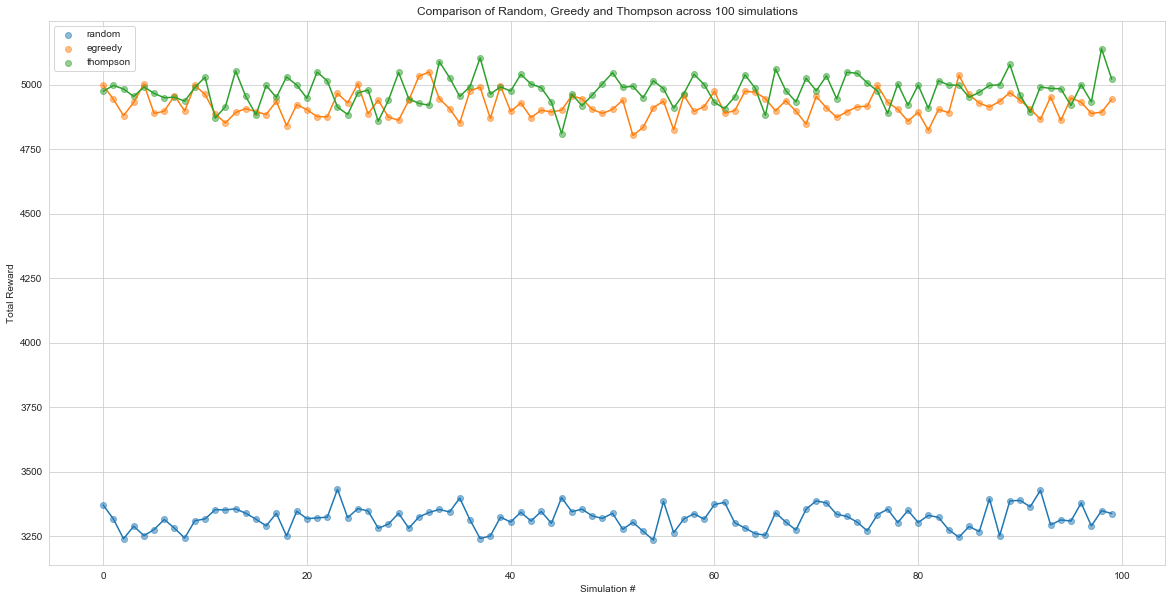

In [16]:
plt.figure(figsize=(20,10))
x = np.arange(0, 100)
plt.scatter(x, rs_scores, label="random", alpha=0.5);
plt.scatter(x, egreedy_scores, label="egreedy", alpha=0.5)
plt.scatter(x, ts_scores, label="thompson", alpha=0.5);
plt.legend();
plt.plot(rs_scores, label="random");
plt.plot(egreedy_scores, label="egreedy")
plt.plot(ts_scores, label="thompson");
plt.xlabel("Simulation #")
plt.ylabel("Total Reward");
plt.title("Comparison of Random, Greedy and Thompson across 100 simulations")
plt.savefig("Desktop/bandit_algo/simualtion_100.jpg")


TypeError: 'ListedColormap' object is not subscriptable

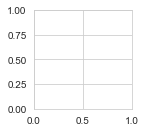

In [32]:
n_rounds = 0
en = Environment(machines, payouts, n_rounds)
tsa = ThompsonSampler(env=en)
plt.subplot(231)
for i in range(len(machines)):
    pdf = beta(tsa.a[i], tsa.b[i]).pdf(x)
    #cmap = list(cmap)
    c = cmap[i]
    plt.plot(x, pdf, c=c, label=i, alpha=.6)
plt.title(f"Prior distribution for each variant (uniform between 0 and 1)")
plt.legend();

TypeError: 'ListedColormap' object is not subscriptable

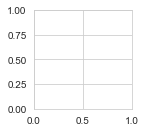

In [31]:
n_rounds = 500
en = Environment(machines, payouts, n_rounds)
tsa = ThompsonSampler(env=en)
en.run(agent=tsa)
plt.subplot(232)
for i in range(len(machines)):
    pdf = beta(tsa.a[i], tsa.b[i]).pdf(x)
    c = cmap[i]
    plt.plot(x, pdf, c=c, label=i, alpha=.6)
plt.title(f"Beta distributions after {n_rounds}")
plt.legend();